<a href="https://colab.research.google.com/github/kartk/ML/blob/main/Decision_Trees_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

-----



# Part 2

This was done as another notebook and the code is identical to the previous one. You can skip to the question details down below the codes

In [ ]:
!pip install pptree

In [ ]:
import numpy as np
from typing import List, Tuple
from ppbtree import print_tree
import matplotlib.pyplot as plt
from collections import Counter 
import warnings
warnings.filterwarnings('ignore')

In [ ]:
class Node:
  """
    @class Node: used to store the binary tree
  """
  def __init__(self, data):
    self.left = None
    self.right = None
    self.data = data
  def pretty_print(self):
      print_tree(self,nameattr="data")


def maxDepth(node):
  """ 
    Function to calculate the maxdepth for a given binary tree 
    Code taken from: https://www.geeksforgeeks.org/write-a-c-program-to-find-the-maximum-depth-or-height-of-a-tree/
  """
  if node is None: 
      return 0 ;    
  else : 
      lDepth = maxDepth(node.left) 
      rDepth = maxDepth(node.right) 
      if (lDepth > rDepth): 
          return lDepth+1
      else: 
          return rDepth+1


class DecisionTree:
  """
    @class DecisionTree: Logic for the decision tree implementation
  """
  def __init__(self,data:np.array = None, k:int=None, m:int=None, d:int = None, s:int = None )-> None:
    """
      constructor:
        Input:
            data  : data to used for training and testing (Optional)
            k     : Number of features the data should have (Optional)
            m     : Size of the data  (Optional)
            d     : Depth up to which to grow the tree (Optional)
            s     : Sampling size (Optional)
    """
    assert ((data is None) and ( m is not None)) or ((data is not None) and ( m is None)), "Both m(size) and data can't be empty" 
    assert ((d is None) and (s is not None)) or ((d is not None) and (s is None)) or ((d is None) and (s is None)), "Give either d(depth size) or s(sample size), not both!"
    self.k = data.shape[1] if data is not None else k
    self.m = data.shape[0] if data is not None else m
    self.data = data if data is not None else DecisionTree.datagenerator2(m)
    self.d = d
    self.s = s
    self.tree = None
    self.nodes = Counter()

  @classmethod
  def datagenerator(self, k:int, m:int)->List[List[int]]:
    """
    Generate data accoriding to the given specification (Q1)
    Input:
      k: number of features
      m: number of data points
    Returns:
      Numpy array of size (m,k+1)
    """
    w_den = sum([np.power(0.9, i) for i in range(2, k+1)])

    data = [[0 for _ in range(k+1)] for _ in range(m)]
    for i in range(m):
      for j in range(k):
        if j == 0 :
          data[i][j] = 0 if np.random.random() <= 0.5 else 1
        if (j >= 1):
          data[i][j] = data[i][j-1] if np.random.random() > 0.25 else 1-data[i][j-1]
        data[i][k] = data[i][0] if (sum([ np.power(0.9, j+2)/w_den * X_j for j, X_j in enumerate(data[i][1:])]) >= 0.5) else (1 - data[i][0])
    return np.array(data)


  @classmethod
  def datagenerator2(self, m:int)->np.array:
    """
    Generate data accoriding to the given specification (Q2)
    Input:
      m: number of data points
    Returns:
      Numpy array of size (m,k)
    """
    data = [[0 for _ in range(22)] for _ in range(m)]
    for i in range(m):
      for j in range(21):
        if j == 0 :
          data[i][j] = 0 if np.random.random() <= 0.5 else 1
        if (j >= 1) and (j<=14):
          data[i][j] = data[i][j-1] if np.random.random() > 0.25 else 1-data[i][j-1]
        if (j >= 15) and (j<21):
          data[i][j] = 0 if np.random.random() <= 0.5 else 1
      data[i][21] = np.bincount(data[i][8:15]).argmax() if data[i][0] else np.bincount(data[i][1:8]).argmax()
    return np.array(data)


  def regenerate_data(self, k=None, m=None)->None:
    """
      Function to regenerate data either. We regenerate the data and store it back as a member variable
    """
    self.data = DecisionTree.datagenerator(k if k else self.k , m if m else self.m) \
    if k is not None else DecisionTree.datagenerator2(m if m is not None else self.m)

  def entropy(self, vector:np.array)->np.array:
    """
      Function to calculate entropy H(Y)
    """
    P_0 = (vector == 0).sum(0) / len(vector)
    P_1 = (vector == 1).sum(0) / len(vector)
    H_Y = - P_0 * np.log2(P_0) - P_1 * np.log2(P_1)
    return H_Y

  def entropy_fit(self, data:np.array, depth=None)->None:
    """
      Function to fit decision tree using ID3, the fitted tree is stored as Node in member variable tree
      Input:
        data  : Data to fit the tree on
        depth : Max depth to grow the tree
    """
    X, Y = data[:,:-1], data[:,-1]
    if (
        (Y == 0).sum(0) == len(Y) or (Y == 1).sum(0) == len(Y) or 
        (depth and self. d is not None and (depth+1 > self.d)) or 
        (self.s is not None and (len(Y) <= self.s))
        ) :
      # Exit Condition for pruning by sample
      if self.s is not None and (len(Y) <= self.s):
        b= np.bincount(data[:,-1])
        max_values = [i for i, x in enumerate(b) if x == max(b)]
        if len(max_values) == 1:
          return Node(f"Y={max_values[0]}")
        else :
          if np.random.random()>0.5:
            return Node(f"Y={max_values[1]}")
          return Node(f"Y={max_values[0]}")

      # Exit Condition for pruning by depth
      if depth and self. d and (depth+1 > self.d):
        return Node(f"Y={np.bincount(data[:,-1]).argmax()}")
      # Exit condition when all Y values are same
      return Node("Y=0") if (Y == 0).sum(0) == len(Y) else Node("Y=1")
    # Calculating H(Y)
    H_Y = max(np.array(0), self.entropy(Y))

    # # Calculating H(Y|X)
    cond_X_Y = []
    for i in range(X.shape[1]):
      P_X_0 = (X[:,i] == 0).sum(0) / len(X[:,i])
      P_X_1 = (X[:,i] == 1).sum(0) / len(X[:,i])
      H_Y_X_0 = max(0, self.entropy(Y[np.where(X[:,i]==0)]))
      H_Y_X_1 = max(0, self.entropy(Y[np.where(X[:,i]==1)]))
      cond_X_Y.append(P_X_0 * H_Y_X_0 + P_X_1 * H_Y_X_1)
    
    # Calculating IG
    IG = H_Y - cond_X_Y

    # Pick the index which has the maximum IG and split on the same
    max_IG = np.argmax(IG)

    # Build a node based on the picked node
    self.nodes[max_IG] += 1
    node = Node(max_IG)

    # Left child would correspond to choosing data where X_maxig == 0
    node.left = self.entropy_fit(data[np.where(data[:,max_IG] == 0)],
                                 depth+1 if depth!=None else None)
    # Left child would correspond to choosing data where X_maxig == 1
    node.right = self.entropy_fit(data[np.where(data[:,max_IG] == 1)], 
                                  depth+1 if depth!=None else None)
    return node

  def gini_fit(self, data:np.array) -> None:
    """
      Function to fit decision tree using Gini index, the fitted tree is stored as Node in member variable tree
      Input:
        data  : Data to fit the tree on
    """

    # Exit condition where all the Y values of data is same 
    if (((data[:,-1]==0).sum(0) == len(data[:,-1])) or ((data[:,-1]==1).sum(0) == len(data[:,-1])) ):
      return Node("Y=0") if (data[:,-1] == 0).sum(0) == len(data[:,-1]) else Node("Y=1")
    gini = []

    # Calculate gini index for each column
    for c in range(data.shape[1] - 1):
      N = len(data[:,c])
      c_0 = data[np.where(data[:,c] == 0)]
      c_1 = data[np.where(data[:,c] == 1)]
      G_c_0 = 1 - ((len(c_0[np.where(c_0[:,-1] == 0)])/c_0.shape[0]) ** 2 if c_0.size != 0 else 0) - \
      ((len(c_0[np.where(c_0[:,-1] == 1)])/c_0.shape[0]) ** 2 if c_0.size != 0 else 0)
      G_c_1 = 1 - ((len(c_1[np.where(c_1[:,-1] == 0)])/c_1.shape[0]) ** 2 if c_1.size != 0 else 0) - \
      ((len(c_1[np.where(c_1[:,-1] == 1)])/c_1.shape[0]) ** 2 if c_1.size != 0 else 0)
      gini.append(c_0.shape[0] / N * G_c_0 + c_1.shape[0] / N * G_c_1)
    gini = np.array(gini)

    # Pick the column which has the minimum gini as the splitting variable
    split_var = gini.argmin()

    # Build a node based on the picked node
    node = Node(split_var)

    # Left child would correspond to choosing data where X_maxig == 0
    node.left = self.gini_fit(data[np.where(data[:,split_var] == 0)])
    
    # Left child would correspond to choosing data where X_maxig == 1
    node.right = self.gini_fit(data[np.where(data[:,split_var] == 1)])
    return node

  def train(self, method:str="entropy")->None:
    """
      Single function to call the training code
      Input:
        method: 
    """
    assert (method == "entropy") or (method == "gini"), "Invalid method argument, Please choose either entropy or gini"
    if method == "entropy":
      self.tree=self.entropy_fit(self.data, 0)
    elif method == "gini":
      self.tree=self.gini_fit(self.data)
  
  def get_y(self, vector:np.array, node:Node) -> int:
    """
      Function that recurses over the tree to get to the leaf
    """

    if type(node.data) == str :
      return int(node.data[-1])
    if vector[node.data] == 0:
      return self.get_y(vector, node.left)
    else:
      return self.get_y(vector, node.right)


  def predict(self, data:np.array)->List:
    """
      Function to predict on the given data
      Input:
        data: data on which to predict
    """

    assert self.tree is not None, "Model not trained yet!! Run train() before predict"
    correct_count = 0
    y = []
    for i in data:
      y.append(self.get_y(i, self.tree))
    return y
  
  def error(self, data:np.array=None) -> float:
    """
      Find the error the trained tree on the given data
      Input:
        data: data on which to find the error
    """
    d = data if data is not None else self.data
    y_hat = self.predict(d[:,:-1])
    y = d[:, -1]
    return 1 - (y_hat == y).sum(0) / len(y)
  
  def estimate_distribution_error(self,m:int=None, N:int=100)->float:
    """
      Find the underlying distribution error. We do this by regenerating the data 
      N times and averaging the error from the regenerated data
      Input:
        m : size of the regenerated data
        N : number of times we need to regenerate the data 
    """
    error = 0
    for i in range(N):
      self.regenerate_data(m = m)
      error += self.error()
    return error / N

# Questions :


1) Write a function to generate m samples of (X, Y ), and another to fit a tree to that data using ID3. Write a
third function to, given a decision tree f , estimate the error rate of that decision tree on the underlying data,
err(f ). Do this repeatedly for a range of m values, and plot the ‘typical’ error of a tree trained on m data
points as a function of m. Does this agree with your intuition?

Ans:

The function to generate m samples is DecisionTree.datagenerator2.



```
  @classmethod
  def datagenerator2(self, m:int)->np.array:
    """
    Generate data accoriding to the given specification (Q2)
    Input:
      m: number of data points
    Returns:
      Numpy array of size (m,k)
    """
    data = [[0 for _ in range(22)] for _ in range(m)]
    for i in range(m):
      for j in range(21):
        if j == 0 :
          data[i][j] = 0 if np.random.random() <= 0.5 else 1
        if (j >= 1) and (j<=14):
          data[i][j] = data[i][j-1] if np.random.random() > 0.25 else 1-data[i][j-1]
        if (j >= 15) and (j<21):
          data[i][j] = 0 if np.random.random() <= 0.5 else 1
      data[i][21] = np.bincount(data[i][8:15]).argmax() if data[i][0] else np.bincount(data[i][1:8]).argmax()
    return np.array(data)
```




In [ ]:
data = DecisionTree.datagenerator2(m=1000)

In [ ]:
data[:10,:]

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1],
       [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1],
       [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0],
       [0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

We can also generate data using DecisionTree class contructor

In [ ]:
dt = DecisionTree(m=10000)

In [ ]:
dt.data[:10,:]

array([[0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0],
       [1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1],
       [0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1],
       [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0],
       [0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1]])

The DecisionTree constructor can also take the already generated data as `DecisionTree(data=data)` and generate an object

In [ ]:
dt = DecisionTree(data=data)

In [ ]:
dt.data[:10,:]

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1],
       [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1],
       [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0],
       [0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

To fit the data, we use the DecisionTree's train method

```
  dt.train()
```




In [ ]:
dt.train()

To estimate the underlying distribution error, call the DecisionTree's estimate_distribution_error

```
dt.estimate_distribution_error(m , N)
```
m: size of the data
N: is the number of times to regenerate the data based on the given scheme

This function regenerates data, using the trained tree to predict and calculate the error


In [ ]:
dt.estimate_distribution_error(N=2000)

0.0695769999999994

The following code plots the error of the distribution against the size of the data

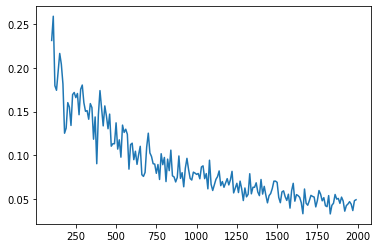

In [ ]:
m_range = np.arange(100, 2000, 10)
error_mrange = []
for i in m_range:
  dt = DecisionTree(m=i)
  dt.train()
  error_mrange.append(dt.estimate_distribution_error(N=100))
plt.plot(m_range, error_mrange)

From the graph we can see that as size of the data increases, the error decreases. This is same as my intuition as more data allows us build deeper trees and deeper trees in turn makes error of the distribution smaller


***

2) Note that X 15 through X 20 are completely irrelevant to predicting the value of Y . For a range of m values,
repeatedly generate data sets of that size and fit trees to that data, and estimate the average number of
irrelevant variables that are included in the fit tree. How much data would you need, typically, to avoid fitting
on this noise?

In [ ]:
dt = DecisionTree(m=100000)

In [ ]:
def percentage_irrelevant(nodes:Counter):
  irrelevant_count = 0
  for i, j in  dt.nodes.items():
    if i > 14:
      irrelevant_count += j
  return irrelevant_count 


In [ ]:
m_range = np.arange(1000, 20000, 1000)
N = 100
total_irrelevant = []
for i in m_range:
  m_irrelevant = 0
  for j in range(N):
    dt = DecisionTree(m=i)
    dt.train()
    m_irrelevant += percentage_irrelevant(dt.nodes)
  total_irrelevant.append(m_irrelevant / N)



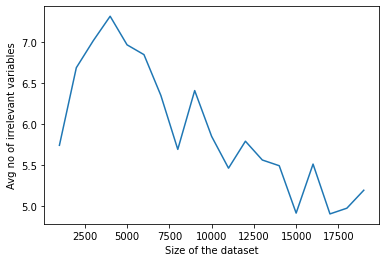

In [ ]:
plt.plot(m_range, total_irrelevant)
plt.xlabel("Size of the dataset")
plt.ylabel("Avg no of irrelevant variables")
plt.show()

For this question, I expect the irrelevant feature to be always there in the decision tree. But the number of irrelevant features in our tree decreases as we increase the size of dataset as can be seen from the graph above which plots the average number of irrelevant features compared to total features against the size of the data. I assume this trend continues and some larger size value the irrelevant features would not be a part of the trees


***

3) Generate a data set of size m = 10000, and set aside 8000 points for training, and 2000 points for testing. The
remaining questions should all be applied to this data set.

In [ ]:
data = DecisionTree.datagenerator2(10000)
np.random.shuffle(data)
train_data, test_data = data[:8000, :], data[8000:,:]

Pruning by depth: Consider growing a tree as a process - running ID3 for instance until all splits
up to depth d have been performed. Depth d = 0 should correspond to no decisions - a prediction for Y
is made just on the raw frequencies of Y in the data. Plot, as a function of d, the error on the training
set and the error on the test set for a tree grown to depth d. What does your data suggest as a good
threshold depth?


We can prune by depth, by sending the depth information as a paramter to the decision tree constructor as follows:


```
DecisionTree(train_data, d = <desirable_depth>)
```



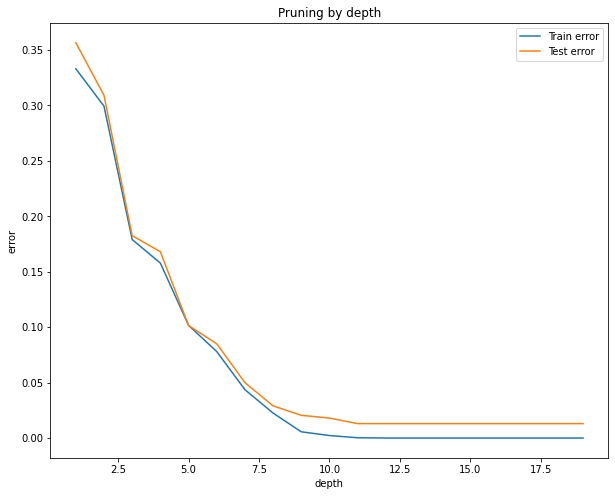

In [ ]:
d_range = np.arange(1,20)
train_error = []
test_error = []
actual_max = []
for i in d_range:
  dt = DecisionTree(train_data, d = i)
  dt.train()
  train_error.append(dt.error())
  test_error.append(dt.error(test_data))
  actual_max.append(maxDepth(dt.tree))
plt.figure(figsize=(10,8))
plt.plot(d_range, train_error, label = "Train error")
plt.plot(d_range, test_error, label="Test error")
plt.legend()
plt.title("Pruning by depth")
plt.xlabel("depth")
plt.ylabel("error")
plt.show()

The graph above shows for a range of d vs error rate for the same

Observations: As d increases, the error decreases and agrees to my intuition as we'll be using more information to predict. Also we see that after around d=8, the error remains constant. I initially thought this was because the max depth of the tree for this data would be 8, but the following graph which plots the depth range vs actual max depth of the tree shows that the actual max is 15

Text(0.5, 1.0, 'Depth range vs actaul max depth of the tree')

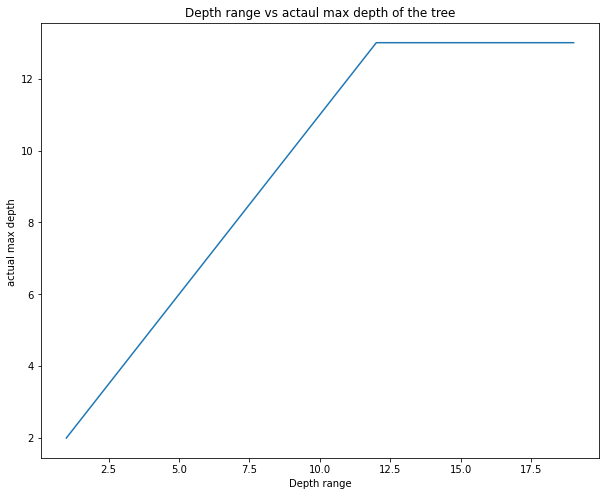

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(d_range, actual_max)
plt.xlabel("Depth range")
plt.ylabel("actual max depth ")
plt.title("Depth range vs actaul max depth of the tree")

This means, by elbow method after a depth of around we wouldn't have much gain and thus we can choose the threshold as 8

b) Pruning by Sample Size: The less data a split is performed on, the less ‘accurate’ we expect the
result of that split to be. Let s be a threshold such that if the data available at a node in your decision
tree is less than or equal to s, you do not split and instead decide Y by simple majority vote (ties broken
by coin flip). Plot, as a function of s, the error on the training set and the error on the testing set for a
tree split down to sample size s. What does your data suggest as a good sample size threshold?

In [ ]:
s_range = np.arange(1, 8000, 10)

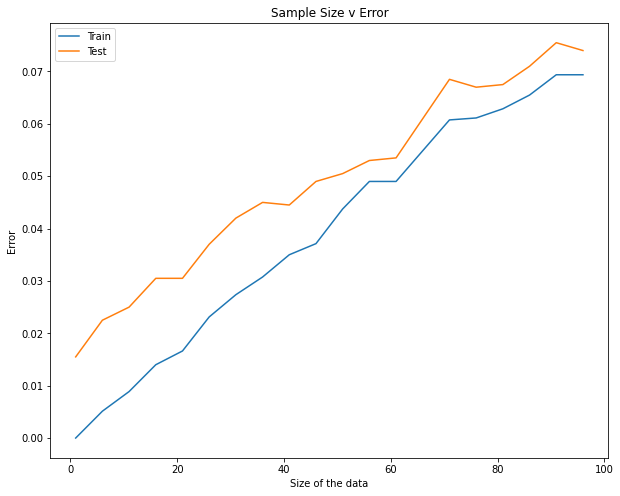

In [ ]:
train_error = []
test_error = []
for i in s_range:
  dt = DecisionTree(train_data, s = i)
  dt.train()
  train_error.append(dt.error())
  test_error.append(dt.error(test_data))
fig, ax = plt.subplots(1,1,figsize=(10,8))
ax.plot((s_range), train_error, label="Train")
ax.plot((s_range), test_error, label="Test")
plt.xlabel("Size of the data")
plt.ylabel("Error")
plt.legend()
plt.title("Sample Size v Error")
plt.show()

Observations: The error decreases as the sample size threshold decreases and it isn't possible to get a threshold from this graph. We see there are a lot of straight line in error as we increase the sample size s, this is because for these ranges of sample size, the tree remains the same

We'll do the same experiment on the a smaller s range:

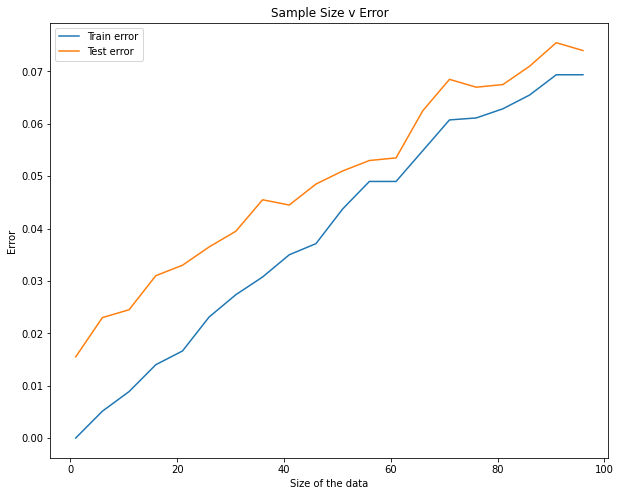

In [ ]:
s_range = np.arange(1, 100, 5)
train_error = []
test_error = []
for i in s_range:
  dt = DecisionTree(train_data, s = i)
  dt.train()
  train_error.append(dt.error())
  test_error.append(dt.error(test_data))
fig, ax = plt.subplots(1,1,figsize=(10,8))
ax.plot((s_range), train_error, label="Train error")
ax.plot((s_range), test_error, label="Test error")
plt.xlabel("Size of the data")
plt.ylabel("Error")
plt.legend()
plt.title("Sample Size v Error")
plt.show()

At around 70, we see a small increase and decrease in the testing error, we'll choose this as our threshold

In [ ]:
a

____

5) Repeat the computation of Problem 2, growing your trees only to depth d as chosen in 3.a. How does this
change the likelihood or frequency of including spurious variables in your trees?

In [ ]:
total_irrelevant_d = []
m_range = np.arange(1000, 20000, 1000)
N = 100
for i in m_range:
  m_irrelevant = 0
  for j in range(N):
    dt = DecisionTree(m=i, d=8)
    dt.train()
    m_irrelevant += percentage_irrelevant(dt.nodes)
  total_irrelevant_d.append(m_irrelevant / N)



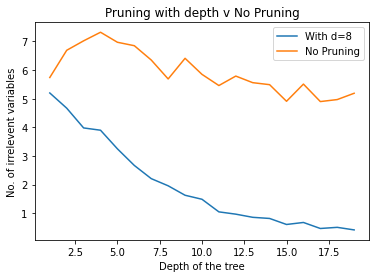

In [ ]:
plt.plot(d_range, total_irrelevant_d, label = "With d=8")
plt.plot(d_range, total_irrelevant, label="No Pruning")
plt.legend()
plt.title("Pruning with depth v No Pruning")
plt.xlabel("Depth of the tree")
plt.ylabel("No. of irrelevent variables")
plt.show()

Observation: From the graph we can clearly see the effect of pruning. It removes more unrrelevant data compared to the No Pruning

***

6) Repeat the computation of Problem 2, splitting your trees only to sample size s as chosen in 3.b. How does
this change the likelihood or frequency of including spurious variables in your trees?

In [ ]:
total_irrelevant_s = []
m_range = np.arange(1000, 10000, 1000)
N = 100
for i in m_range:
  m_irrelevant = 0
  for j in range(N):
    dt = DecisionTree(m=i, s=70 )
    dt.train()
    m_irrelevant += percentage_irrelevant(dt.nodes)
  total_irrelevant_s.append(m_irrelevant / N)



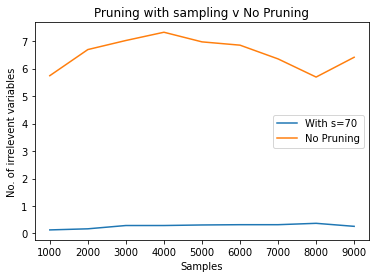

In [ ]:
plt.plot(m_range, total_irrelevant_s, label = "With s=70")
plt.plot(m_range, total_irrelevant[:9], label="No Pruning")
plt.legend()
plt.title("Pruning with sampling v No Pruning")
plt.xlabel("Samples")
plt.ylabel("No. of irrelevent variables")
plt.show()

Observation: From the graph we can clearly see the effect of pruning. It removes more unrrelevant data compared to the No Pruning.